In [1]:
import numpy as np
from scipy.io import wavfile
import warnings
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Audio, display


# Error in Frequency Analysis of Piano Recordings
##### two approaches to finding maxima in discrete sets, and analysis of their performance on noise-augmented frequency data
Yijia, Jaden, Hudson





#### Overview
- Problem: how can a computer analyze an audio file, and know what notes are being played when?
- Fourier Transform: signal processing function, which decomposes a complex wave into a set of simple frequencies, and their relative power (transform from time domain to frequency domain)
- In the frequency domain, we can see peaks at different bands, indicating that those frequencies are dominant in the sample
- By taking small chunks of an audio file, and transforming them to the frequency domain, we can map the notes being played back into the time domain (with some loss)


#### A Little Music Theory:
harmonics are multiples of the fundamental frequency. So if the fundamental frequency is 100 Hz, the higher harmonics will be 200 Hz, 300 Hz, 400 Hz, 500 Hz, and so on. If the fundamental frequency were 220 Hz, the harmonics would be 440 Hz, 660 Hz, 880 Hz, and so on.

- you can see these harmonics show up on the graph below, which animates the frequency domain of this chromatic scale

In [16]:
wav_file = "midi/midi_prog.wav"
display(Audio(wav_file))
#Now generate animation
plt.switch_backend('Agg')
arrays = []
for i in np.arange(0, 12, 0.5):
    arrays.append(get_fft_at_slice(i, 0.5, 'midi/midi_prog.wav', plot=False))
fig, ax = plt.subplots()
line, = ax.plot([], [])

def init():
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 20000)
    return line,

def update(frame):
    data = arrays[frame] 
    line.set_data(range(len(data)), data)
    return line,

ani = FuncAnimation(fig, update, frames=len(arrays), init_func=init, blit=True)

HTML(ani.to_jshtml())

#### So What's The Problem??

- we need to find the extrema of this frequency/power plot. Their indices will tell us the dominant note frequencies in our samples
- to do this, we could always run good ole argmax() on our list (O(n) time)
- We want to find a quicker way.


#### Approach #1 -> Linear Scan

# Jaden could you fill this part out and insert your linear scan code below. Thanks

#### Approach #2 -> Gradient Descent

- takes in array, with set of guesses
- at each guess, takes difference of arr[index] and arr[index + 1], to estimate a rate of change
- inverts rates < 0, and multiplies by -1
- adds adjusted rate * learning rate to each guesses index, and iterates again.
- checks each final value against its index neighbors to reduce error
- speed at the expense of some accuracy

In [9]:

def gradient_descent_2(arr, guesses, max_iter, show_results, inititial_run, learning_rate=10):

    start_time = time.time()
    maxes = []

    for guess in guesses:
        dynamic_learning_rate = learning_rate
        index = guess
        max = arr[guess]
        max_index = guess
        for i in range(1, max_iter):
            if(index<0):
                index = 0
            dynamic_learning_rate = dynamic_learning_rate*0.95
            if(arr[index]>max):
                max_index = index
                max = arr[index]

            grad = (arr[index+1]/arr[index])
            if(grad < 1):
                grad = -1/grad
            index += int(grad*dynamic_learning_rate)
        maxes.append(max_index)

    returnval = (get_prox(arr, maxes, 60))

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if(show_results == True):
        print("===== iteration results =====")
        print("max value found: ", max)
        print("maximum index: ", returnval)
        print("time elapsed: ", elapsed_time)
        print("============================")
    return returnval
    #return maxes
    #return maxes[np.argmax(arr[maxes])]

In [10]:
def plot_error_freq(arr, window_size, x_values):
    moving_avg = np.convolve(arr, np.ones(window_size) / window_size, mode='valid')
    #plt.plot(arr, label='Original Data')
    pad_left = (len(x_values) - len(moving_avg)) // 2
    pad_right = len(x_values) - len(moving_avg) - pad_left
    moving_avg = np.pad(moving_avg, (pad_left, pad_right), mode='constant', constant_values=0)

    plt.plot(x_values, moving_avg)
    plt.xlabel('FFT Chunk Size')
    plt.ylabel('Error')
    plt.title('Moving Average of Error Freq.')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def get_error_freq(arr, window_size, x_values):
    moving_avg = np.convolve(arr, np.ones(window_size) / window_size, mode='valid')
    #plt.plot(arr, label='Original Data')
    pad_left = (len(x_values) - len(moving_avg)) // 2
    pad_right = len(x_values) - len(moving_avg) - pad_left
    moving_avg = np.pad(moving_avg, (pad_left, pad_right), mode='constant', constant_values=0)

    return moving_avg

In [12]:
def plot_errors(path):
    errors = []
    for slice_size in np.arange(0.05, 2, 0.005):
        for i in range(0, 1):
            slice = get_fft_at_slice(i, slice_size, path, plot=False)
            # print(len(slice))
            freq = gradient_descent_2(slice, guesses=[100, 200, 300, 400, 500], max_iter=300, show_results=False, inititial_run=True)
            true_value = np.argmax(slice)
            errors.append(abs(true_value-freq))

    plot_error_freq(errors, 30, np.arange(0.05, 2, 0.005))
    print(errors)
    print("average error", np.sum(errors)/len(errors))
    x_values = np.arange(0.05, 2, 0.005)
    y_values = errors

    plt.plot(x_values, y_values)
    plt.xlabel('slice size')
    plt.ylabel('error')
    plt.title('Plot of errors')
    plt.grid(True)
    plt.show()

In [14]:
def get_prox(arr, guesses, num):
    max = 0
    max_index = 0
    for i in guesses:
        for j in range(-1*int(num/2), int(num/2)):
            if(arr[i+j]>max):
                max = arr[i+j]
                max_index = i+j
    return max_index





In [17]:
slice_size = 0.2
for i in range(0, 1):
    slice = get_fft_at_slice(i, slice_size, 'sample_1.wav', plot=False)
    #print(len(slice))
    freq = gradient_descent_2(slice, guesses=[100, 200, 300, 400, 500, 600, 700, 800], max_iter=200, inititial_run=True, show_results=True)
    
    print("true value -> ", np.argmax(slice))

===== iteration results =====
max value found:  56528962.17328348
maximum index:  105
time elapsed:  0.001070261001586914
true value ->  105


C:\Users\hudso\AppData\Local\Temp\ipykernel_15592\4121391281.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(path)


In [191]:
errors = []
x_range = np.arange(0.05, 2, 0.01)
for slice_size in x_range:
    for i in range(0, 1):
        slice = get_fft_at_slice(i, slice_size, 'midi/midi_2.wav', plot=False)
        #print(len(slice))
        freq = gradient_descent_2(slice, guesses=[100, 200, 300, 400, 500, 600, 700, 800], max_iter=200, inititial_run=True, show_results=False)
        true = np.argmax(slice)

        while freq > 280:
            freq = freq/2
        while true >280:
            true = true/2
        
        errors.append(abs(freq-true))

plot_error_freq(errors, 50, x_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


: 

In [43]:
%matplotlib inline
to_save = []
for x in range(0, 16):
    print("iteration: ", int(x))
    filename = 'midi/midi_' + str(x) + '.wav'
    errors = []
    x_range = np.arange(0.05, 2, 0.01)
    for slice_size in x_range:
        for i in range(0, 1):
            slice = get_fft_at_slice(i, slice_size, filename, plot=False)
            #print(len(slice))
            freq = gradient_descent_2(slice, guesses=[100, 200, 300, 400, 500, 600, 700, 800], max_iter=200, inititial_run=True, show_results=False)
            true = np.argmax(slice)

            while freq > 280:
                freq = freq/2
            while true >280:
                true = true/2
            
            errors.append(abs(freq-true))
    to_save.append(get_error_freq(errors, 50, x_range))

np.save('prelim_test_values.npy', to_save)



iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
[]


16


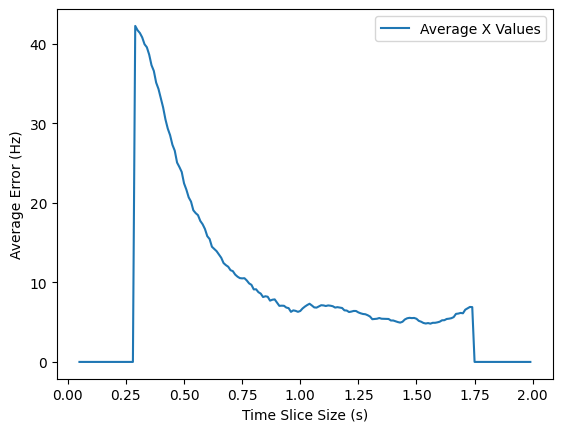

In [28]:
loaded_arr = np.load('prelim_test_values.npy')
print(len(loaded_arr))

average_x = np.mean(loaded_arr, axis=0)
x_range = np.arange(0.05, 2, 0.01)

plt.plot(x_range, average_x,  label='Average X Values')

plt.xlabel('Time Slice Size (s)')
plt.ylabel('Average Error (Hz)')
plt.legend()

plt.show()

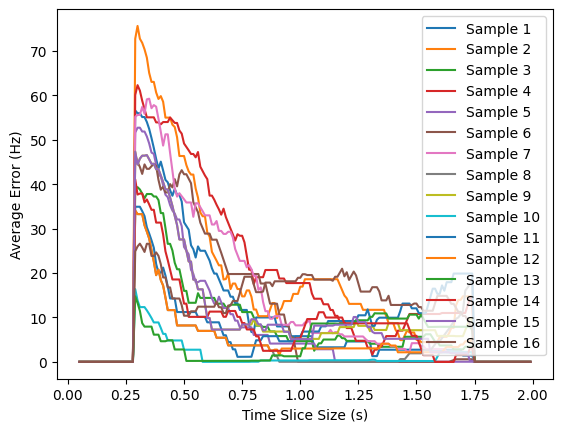

In [30]:
loaded_arr = np.load('prelim_test_values.npy')

x_range = np.arange(0.05, 2, 0.01)
for i, x in enumerate(loaded_arr):
    plt.plot(x_range, x, label=f'Sample {i+1}')


plt.xlabel('Time Slice Size (s)')
plt.ylabel('Average Error (Hz)')
plt.legend()

plt.show()

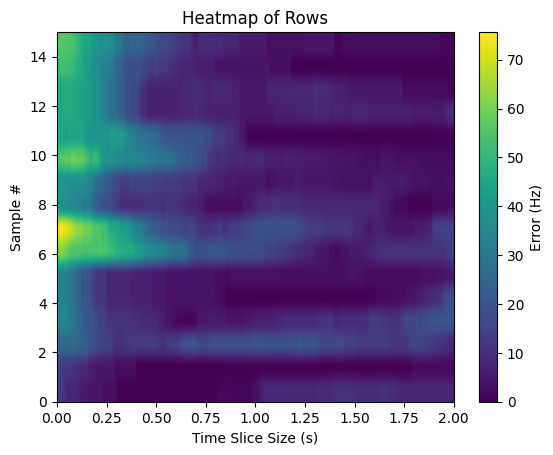

In [55]:
trimmed = []
for x in loaded_arr:
    start_index = np.argmax(x != 0)
    end_index = len(x) - np.argmax(x[::-1] != 0)
    trimmed_x = x[start_index:end_index]
    trimmed.append(trimmed_x)
    
def euclidean_distance(list1, list2):
    return np.linalg.norm(np.array(list1) - np.array(list2))
x_range = np.arange(0.05, 2, 0.01)
trimmed = sorted(trimmed, key=lambda x: euclidean_distance(trimmed[0], x))
left = 0
right = 2
bottom = 0
top = 15
extent = [left, right, bottom, top]
plt.imshow(trimmed, cmap='viridis', aspect='auto', extent=extent)


plt.xlabel('Time Slice Size (s)')
plt.ylabel('Sample #')
plt.title('Heatmap of Rows')
plt.colorbar(label='Error (Hz)')
plt.show()

C:\Users\hudso\AppData\Local\Temp\ipykernel_5028\4121391281.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(path)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


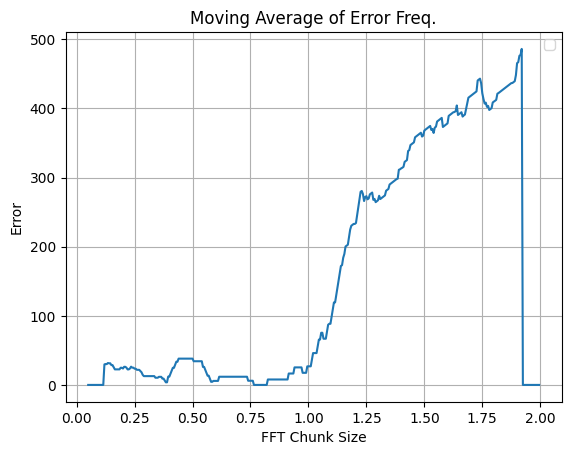

[38, 57, 63, 68, 0, 79, 0, 90, 95, 0, 0, 0, 0, 0, 0, 33, 0, 0, 37, 153, 0, 41, 0, 44, 0, 45, 0, 49, 0, 0, 52, 54, 110, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 0, 74, 0, 0, 77, 0, 80, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 0, 247, 0, 126, 127, 129, 0, 131, 133, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 2, 287, 287, 0, 0, 0, 292, 294, 0, 296, 0, 0, 0, 0, 304, 304, 306, 0, 308, 309, 311, 0, 313, 315, 316, 317, 319, 319, 321, 166, 323, 325, 326, 328, 329, 167, 332, 333, 0, 336, 336, 338, 340, 340, 342, 172, 0, 172, 347, 173, 350, 176, 353, 353, 0, 357, 179, 359, 361, 362, 182, 364, 366, 367, 368, 370, 371, 372, 191, 374, 376

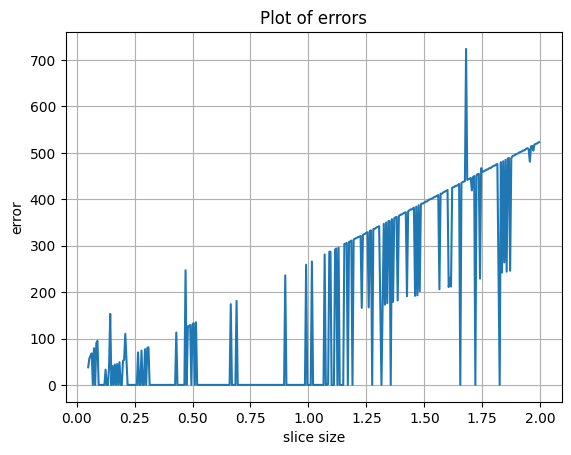

In [129]:
plot_errors("sample_1.wav")

In [15]:
def get_fft_at_slice(start, duration, path, plot):

    fs, data = wavfile.read(path)
    time_slice = duration
    start_samples = int(start*fs)
    num_samples = int(time_slice * fs)

    transform_data = data[start_samples:start_samples + num_samples]
    a = transform_data.T[0]
    b = [(ele / 2 ** 8.) * 2 - 1 for ele in a]
    c = fft(b)
    d = int(len(c) / 2)

    if plot:
        d = 2000
        plt.plot(abs(c[:(d - 1)]), 'r')
        plt.show()
        return abs(c[:(d - 1)])
    else:
        return abs(c[:(d - 1)])
